In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [3]:
df = pd.read_csv("cleaned_dataset.csv")

df = df[["processed_image_path", "Surgery_Advisable"]]
print(f"Dataset size: {len(df)} samples")
print(df["Surgery_Advisable"].value_counts())

Dataset size: 986 samples
Surgery_Advisable
1    707
0    279
Name: count, dtype: int64


In [4]:
class SurgeryDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["processed_image_path"]
        label = int(self.df.iloc[idx]["Surgery_Advisable"])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


In [5]:
train_df, val_df = train_test_split(df, test_size=0.2, 
                                    stratify=df["Surgery_Advisable"], 
                                    random_state=42)


In [6]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

In [7]:
train_dataset = SurgeryDataset(train_df, transform=train_transform)
val_dataset = SurgeryDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [8]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df["Surgery_Advisable"]),
    y=df["Surgery_Advisable"]
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class Weights:", class_weights)

Class Weights: tensor([1.7670, 0.6973], device='mps:0')


In [9]:
model = models.convnext_small(pretrained=True)
model.classifier[2] = nn.Linear(model.classifier[2].in_features, 2)
model = model.to(device)

/Users/yaswanth/Downloads/SetProject/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yaswanth/Downloads/SetProject/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


In [11]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    scheduler.step()
    avg_loss = total_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_loss:.4f}")

Epoch 1/10: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch [1/10] - Train Loss: 0.6788


Epoch 2/10: 100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


Epoch [2/10] - Train Loss: 0.5482


Epoch 3/10: 100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


Epoch [3/10] - Train Loss: 0.4605


Epoch 4/10: 100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


Epoch [4/10] - Train Loss: 0.3363


Epoch 5/10: 100%|██████████| 50/50 [00:39<00:00,  1.25it/s]


Epoch [5/10] - Train Loss: 0.2385


Epoch 6/10: 100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


Epoch [6/10] - Train Loss: 0.2182


Epoch 7/10: 100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


Epoch [7/10] - Train Loss: 0.1164


Epoch 8/10: 100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


Epoch [8/10] - Train Loss: 0.1021


Epoch 9/10: 100%|██████████| 50/50 [00:39<00:00,  1.28it/s]


Epoch [9/10] - Train Loss: 0.0623


Epoch 10/10: 100%|██████████| 50/50 [00:39<00:00,  1.28it/s]

Epoch [10/10] - Train Loss: 0.0547


In [12]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


=== Evaluation Results (ConvNeXt-Small — Surgery Prediction) ===
Accuracy : 0.8485
Precision: 0.9058
Recall   : 0.8803
F1 Score : 0.8929

Classification Report:

              precision    recall  f1-score   support

  No Surgery       0.72      0.77      0.74        56
     Surgery       0.91      0.88      0.89       142

    accuracy                           0.85       198
   macro avg       0.81      0.82      0.82       198
weighted avg       0.85      0.85      0.85       198



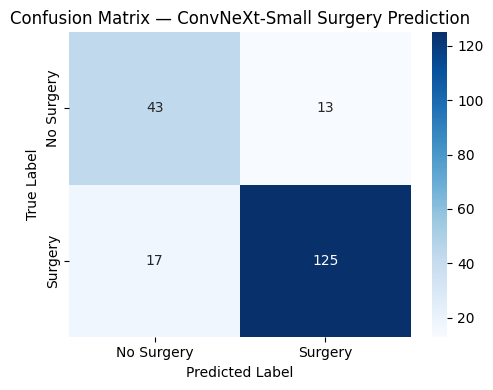

In [14]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\n=== Evaluation Results (ConvNeXt-Small — Surgery Prediction) ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["No Surgery", "Surgery"]))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Surgery", "Surgery"],
            yticklabels=["No Surgery", "Surgery"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — ConvNeXt-Small Surgery Prediction")
plt.tight_layout()
plt.show()

In [15]:
torch.save(model.state_dict(), "surgery_convnext_small.pth")